In [31]:
import matplotlib.pyplot as plt # Import the Matplotlib package
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
 
import numpy as np # Import the Numpy package
 
from remap import remap2 # Import the Remap function
 
# from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
 
import datetime # Library to convert julian day to dd-mm-yyyy
 
from matplotlib.patches import Rectangle # Library to draw rectangles on the plot
 
from netCDF4 import Dataset # Import the NetCDF Python interface

import glob


In [40]:
root_dir = r'C:\Projects\RD\OPIR_GOES\GOES\ABI-L1b-RadC\2017\282\05'
root_dir = r'C:\Projects\RD\OPIR_GOES\GOES\from_jeff'
b6_paths = glob.glob(root_dir + r'\OR_ABI-L1b-RadC-M3C06_G16_*')

print(b6_paths)

# store some variables
time_ls = []
data_ls = []
grid_ls = []
date_ls = []

for path in b6_paths:
     
    # Getting information from the file name ==============================================================
    # Search for the Scan start in the file name
    Start = (path[path.find("_s")+2:path.find("_e")])
    # Search for the GOES-16 channel in the file name
    Band = int((path[path.find("M3C" or "M4C")+3:path.find("_G16")]))
    # Create a GOES-16 Bands string array
    Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
     
    # Converting from julian day to dd-mm-yyyy
    year = int(Start[0:4])
    dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
    dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
    date = dayconventional.strftime('%d-%b-%Y') # Format the date according to the strftime directives
    date_ls.append(date)
    
    time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
    time_ls.append(time)
    
    # Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
    if Band <= 6:
        Unit = "Reflectance"
    else:
        Unit = "Brightness Temperature [°C]"

    # Open the file using the NetCDF4 library
    nc = Dataset(path)
     
    # Get the latitude and longitude image bounds
    geo_extent = nc.variables['geospatial_lat_lon_extent']
    min_lon = float(geo_extent.geospatial_westbound_longitude)
    max_lon = float(geo_extent.geospatial_eastbound_longitude)
    min_lat = float(geo_extent.geospatial_southbound_latitude)
    max_lat = float(geo_extent.geospatial_northbound_latitude)
     
    # Choose the visualization extent (min lon, min lat, max lon, max lat)
    #extent = [-85.0, -5.0, -60.0, 12.0]
    extent = [min_lon, min_lat, max_lon, max_lat]
     
    # Choose the image resolution (the higher the number the faster the processing is)
    resolution = 2.0
     
    # Calculate the image extent required for the reprojection
    H = nc.variables['goes_imager_projection'].perspective_point_height
    x1 = nc.variables['x_image_bounds'][0] * H
    x2 = nc.variables['x_image_bounds'][1] * H
    y1 = nc.variables['y_image_bounds'][1] * H
    y2 = nc.variables['y_image_bounds'][0] * H
     
    # Call the reprojection function
    raw,grid = remap2(path, extent, resolution, x1, y1, x2, y2)
    grid_ls.append(grid)
     
    # Read the data returned by the function
    if Band <= 6:
        data = grid.ReadAsArray()
    else:
        # If it is an IR channel subtract 273.15 to convert to ° Celsius
        data = grid.ReadAsArray() - 273.15
        
    data_ls.append(data)

['C:\\Projects\\RD\\OPIR_GOES\\GOES\\from_jeff\\OR_ABI-L1b-RadC-M3C06_G16_s20172920002122_e20172920004501_c20172920004549.nc', 'C:\\Projects\\RD\\OPIR_GOES\\GOES\\from_jeff\\OR_ABI-L1b-RadC-M3C06_G16_s20172920007122_e20172920009501_c20172920009546.nc', 'C:\\Projects\\RD\\OPIR_GOES\\GOES\\from_jeff\\OR_ABI-L1b-RadC-M3C06_G16_s20172920012122_e20172920014501_c20172920014543.nc', 'C:\\Projects\\RD\\OPIR_GOES\\GOES\\from_jeff\\OR_ABI-L1b-RadC-M3C06_G16_s20172920017122_e20172920019501_c20172920019548.nc']


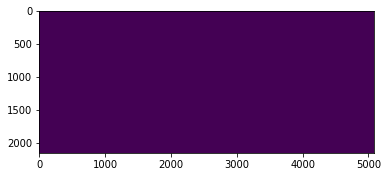

In [35]:
# make the list into an array (time will be dim=0)
data_arr = np.array(data_ls)    

# make an array of zeros to match
shp = data_ls[0].shape
targets = np.zeros((shp[0]*shp[1],1))

# reshape
data_arr = np.rollaxis(data_arr, 0, 3)
data_vec = np.reshape(data_arr, (shp[0]*shp[1], -1))

# make into a pandas data frame
import pandas as pd
        
dts = []
for i,t in enumerate(time_ls):
    s = 'UTC_' + t.replace(':','').replace(' ','').replace('UTC', '')
    dt = (s, 'float32')    
    dts.append(dt)
    
# restructure the numpy array for use in a pandas dataframe
myRecord = np.core.records.array(list(tuple(data_vec.transpose())), dtype=dts)
df = pd.DataFrame(myRecord)


absmax = data_vec.max(axis=1).max()
loc = np.where(data_vec.max(axis=1) == absmax)[0]

targets[loc]=1
plt.imshow(np.reshape(targets, (shp[0], shp[1])))
plt.show()

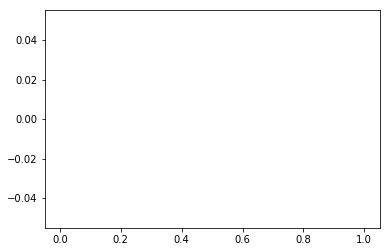

In [36]:
arr_vars = np.var(data_vec, axis=1)
hist, bins, _ = plt.hist(arr_vars[arr_vars>0], bins=255)
plt.show()


In [37]:
bins[-1]

1.0

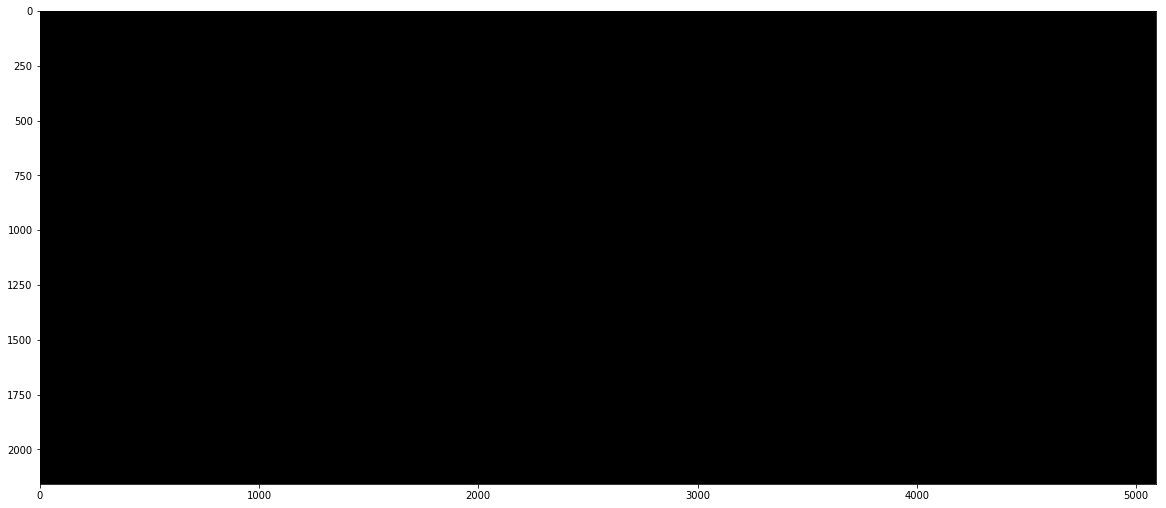

In [41]:
vars_hi_im = np.reshape(arr_vars>bins[-254], (shp[0], shp[1]))
vars_im = np.reshape(arr_vars, (shp[0], shp[1]))
fig = plt.figure(figsize=(20,20))
plt.imshow(vars_im, cmap='bone', vmin=0., vmax=80)
plt.show()

#### Write out one of the rasters

In [39]:
from osgeo import gdal, osr
driver = gdal.GetDriverByName('GTiff')
rows,cols = data_ls[0].shape

fname = dts[0][0] + "_" + date_ls[0].replace('-','') + '_GOES_L1B_RAD_fromJeff.tif'
dst_ds = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
dst_ds.SetGeoTransform(grid_ls[0].GetGeoTransform())
#srs = osr.SpatialReference()
#srs.ImportFromWkt(projInfo)
dst_ds.SetProjection(grid_ls[0].GetProjection()) 

# Write out_arr to band
dst_ds.GetRasterBand(1).WriteArray(data_ls[0])

# Flush to disk and close file
dst_ds.FlushCache()
dst_ds = None



In [21]:
grid2 = grid.ReadAsArray()
raw.shape, grid.ReadAsArray().shape

((1500, 2500), (2157, 5089))

31.9973146667


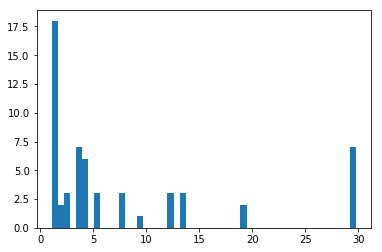

In [27]:
print(raw.mean())
plt.hist(grid2[grid2>1].ravel(), bins=50)
plt.show()

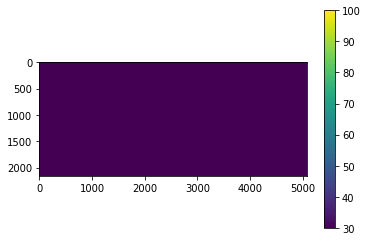

In [22]:
plt.imshow(grid2, vmin=30, vmax=100)
plt.colorbar()

In [23]:
grid2.mean() - raw.mean()

-32.350648676314037